<a href="https://colab.research.google.com/github/rsastri21/QMLResearch/blob/main/427_Lab4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lab 4 Report: 
## Surpass Human Performance in Fashion MNIST Classificaion

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [8]:
!pip uninstall scikit-learn -y 

!pip install -U scikit-learn

Found existing installation: scikit-learn 1.0.2
Uninstalling scikit-learn-1.0.2:
  Successfully uninstalled scikit-learn-1.0.2
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.8/9.8 MB 88.2 MB/s eta 0:00:00


### Name: Rohan Sastri

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import torch
import numpy as np

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

In [3]:
from IPython.display import Image # For displaying images in colab jupyter cell

In [3]:
Image('lab4_exercise.png', width = 1000)

NameError: ignored

## Prepare Data

In [37]:
# Load Fashion-MNIST Dataset in Numpy

# 10000 training features/targets where each feature is a greyscale image with shape (28, 28)
train_features = np.load('/content/drive/MyDrive/Colab Notebooks/427_Labs/Lab4_Template/fashion_mnist_train_features.npy') 
train_targets = np.load('/content/drive/MyDrive/Colab Notebooks/427_Labs/Lab4_Template/fashion_mnist_train_targets.npy')

# 1000 testing features/targets 
test_features = np.load('/content/drive/MyDrive/Colab Notebooks/427_Labs/Lab4_Template/fashion_mnist_test_features.npy')
test_targets = np.load('/content/drive/MyDrive/Colab Notebooks/427_Labs/Lab4_Template/fashion_mnist_test_targets.npy')

# Let's see the shapes of training/testing datasets
print("Training Features Shape: ", train_features.shape)
print("Training Targets Shape: ", train_targets.shape)
print("Testing Features Shape: ", test_features.shape)
print("Testing Targets Shape: ", test_targets.shape)

Training Features Shape:  (10000, 28, 28)
Training Targets Shape:  (10000,)
Testing Features Shape:  (1000, 28, 28)
Testing Targets Shape:  (1000,)


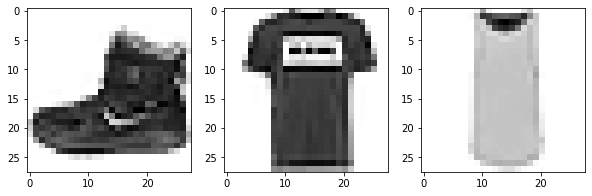

In [5]:
# Visualizing the first three training features (samples)

plt.figure(figsize = (10, 10))

plt.subplot(1,3,1)
plt.imshow(train_features[0], cmap = 'Greys')

plt.subplot(1,3,2)
plt.imshow(train_features[1], cmap = 'Greys')

plt.subplot(1,3,3)
plt.imshow(train_features[2], cmap = 'Greys')

In [38]:
# Perform standard scaling on the training and testing features
# After scaling, make sure you reshape the training features back to (10000, 28, 28) and testing features to (1000, 28, 28)
# since CNNs take 2D tensors as inputs

train_features_flat = train_features.reshape((10000, 28 * 28))
test_features_flat = test_features.reshape((1000, 28 * 28))

scaler = StandardScaler()

train_features = scaler.fit_transform(train_features_flat).reshape((10000, 28, 28))
test_features = scaler.fit_transform(test_features_flat).reshape((1000, 28, 28))

In [39]:
# Take the first 1000 (or randomly select 1000) training features and targets as validation set 

validation_features = train_features[:1000]
validation_targets = train_targets[:1000]

# Take the remaining 9000 training features and targets as training set 

train_features = train_features[1000:]
train_targets = train_targets[1000:]

In [40]:
# Reshape train/validation/test sets to conform to PyTorch's (N, Channels, Height, Width) standard for CNNs

train_features = np.reshape(train_features, (9000, 1, 28, 28))
validation_features = np.reshape(validation_features, (1000, 1, 28, 28))
test_features = np.reshape(test_features, (1000, 1, 28, 28))

## Define Model

In [36]:
# Define your CNN architecture here

class CNNModel(torch.nn.Module):
    
    def __init__(self):
        
        super(CNNModel, self).__init__()
        
        self.cnn1 = torch.nn.Conv2d(in_channels=1, out_channels=16,
                                    kernel_size=5, stride=1, padding=2)
        self.maxpool1 = torch.nn.MaxPool2d(kernel_size=2)
        self.cnn2 = torch.nn.Conv2d(in_channels=16, out_channels=32,
                                    kernel_size=5, stride=1, padding=2)
        self.maxpool2 = torch.nn.MaxPool2d(kernel_size=2)
        self.fc1 = torch.nn.Linear(32 * 7 * 7, 10)
    
    def forward(self, x):
        
        # YOUR CODE HERE
        # Note: If you are using CrossEntropyLoss() do NOT apply softmax to the final ouput 
        # since it's incorporated within the loss function

        conv1_out = torch.nn.functional.relu(self.cnn1(x))
        pool1_out = self.maxpool1(conv1_out)

        conv2_out = torch.nn.functional.relu(self.cnn2(pool1_out))
        pool2_out = self.maxpool2(conv2_out)

        fcn_input = pool2_out.view(pool2_out.size(0), -1)

        output = self.fc1(fcn_input)
        
        return output
    

## Select Hyperparameters

In [41]:
# Fix the random seed so that model performance is reproducible
torch.manual_seed(55)

# Initialize your CNN model

model = CNNModel()

# Define learning rate, epoch and batchsize for mini-batch gradient

learning_rate = 0.003
epochs = 20
batchsize = 100

# Define loss function and optimizer

loss_func = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)

if torch.cuda.is_available():
    model.cuda()

## Identify Tracked Values

In [42]:
# Placeholders for training loss and validation accuracy during training
# Training loss should be tracked for each iteration (1 iteration -> single forward pass to the network)
# Validation accuracy should be evaluated every 'Epoch' (1 epoch -> full training dataset)
# If using batch gradient, 1 iteration = 1 epoch

train_loss_list = []
validation_accuracy_list = np.zeros((epochs,))

## Train Model

In [43]:
import tqdm # Use "for epoch in tqdm.trange(epochs):" to see the progress bar

# Convert the training, validation, testing dataset (NumPy arrays) into torch tensors
# Split your training features/targets into mini-batches if using mini-batch gradient

train_inputs = torch.from_numpy(train_features).float().cuda()
train_targets = torch.from_numpy(train_targets).long().cuda()

validation_inputs = torch.from_numpy(validation_features).float().cuda()
validation_targets = torch.from_numpy(validation_targets).long().cuda()

testing_inputs = torch.from_numpy(test_features).float().cuda()
testing_targets = torch.from_numpy(test_targets).long().cuda()

train_batches_features = torch.split(train_inputs, batchsize)
train_batches_targets = torch.split(train_targets, batchsize)

batch_split_num = len(train_batches_features)
 
# Training Loop ---------------------------------------------------------------------------------------

for epoch in tqdm.trange(epochs):
    
    for k in range(batch_split_num):

      optimizer.zero_grad()

      train_batch_outputs = model(train_batches_features[k])

      loss = loss_func(train_batch_outputs, train_batches_targets[k])

      train_loss_list.append(loss.item())

      loss.backward()

      optimizer.step()

    # Compute Validation Accuracy ----------------------------------------------------------------------

    with torch.no_grad():

      validation_outputs = model(validation_inputs)

      correct = (torch.argmax(validation_outputs, dim=1) == validation_targets).type(torch.FloatTensor)

      validation_accuracy_list[epoch] = correct.mean()


100%|██████████| 20/20 [00:03<00:00,  5.25it/s]


## Visualize & Evaluate Model

In [25]:
# Seaborn for prettier plot

import seaborn as sns

sns.set(style = 'whitegrid', font_scale = 1)

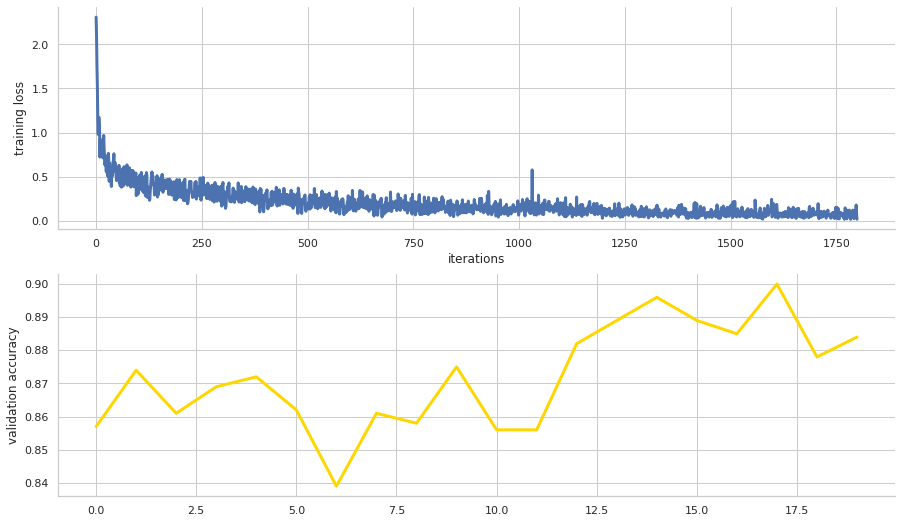

In [44]:
# Visualize training loss

plt.figure(figsize = (15, 9))

plt.subplot(2, 1, 1)
plt.plot(train_loss_list, linewidth = 3)
plt.ylabel("training loss")
plt.xlabel("iterations")
sns.despine()

plt.subplot(2, 1, 2)
plt.plot(validation_accuracy_list, linewidth = 3, color = 'gold')
plt.ylabel("validation accuracy")
sns.despine()

In [45]:
# Compute the testing accuracy 

with torch.no_grad():

  y_pred_test = model(testing_inputs)

  correct = (torch.argmax(y_pred_test, dim=1) == testing_targets).type(torch.FloatTensor)

  print("Testing Accuracy: " + str(correct.mean().numpy()))

Testing Accuracy: 0.864


In [ ]:
# (OPTIONAL) Print the testing accuracy for each fashion class. Your code should produce something that looks like:
# Clever usage of np.where() could be useful here

# "Accuracy of T-shirt/top: 93.5 %"
# "Accuracy of Trouser: 89.3 %"
# etc...

# What's the fashion item that your model had the hardest time classifying?

# YOUR CODE HERE